In [1]:
import xarray as xr
from GadiClient import GadiClient
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import datetime as dt
from itertools import product
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

In [2]:
experiment = "historical"
models = ["ACCESS1-3", "ACCESS1-0", "BNU-ESM", "CNRM-CM5", "GFDL-CM3",\
           "GFDL-ESM2G", "GFDL-ESM2M", "IPSL-CM5A-LR", "IPSL-CM5A-MR",\
                   "MIROC5", "MRI-CGCM3", "bcc-csm1-1"]

hist_list = []
for m in models:
    hist_list.append(xr.open_dataset("/g/data/eg3/ab4502/ExtremeWind/aus/regrid_1.5/clustering_v2_"+m+"_"+experiment+"_1979_2005.nc"))

experiment = "rcp85"
rcp_list = []
for m in models:
    rcp_list.append(xr.open_dataset("/g/data/eg3/ab4502/ExtremeWind/aus/regrid_1.5/clustering_v2_"+m+"_"+experiment+"_2081_2100.nc"))


In [3]:
f = xr.concat(hist_list,dim="models")
r = xr.concat(rcp_list,dim="models")

In [5]:
#Reconstruct times from "number of months" to datetimes

def recon_time():
    start = dt.datetime(1979,1,1)
    out = []
    while start < dt.datetime(2006,1,1):
        out.append(start)
        if start.month < 12:
            start = start.replace(month=start.month+1)
        else:
            start = start.replace(year=start.year+1, month=1)
    return out

def recon_time2():
    start = dt.datetime(2081,1,1)
    out = []
    while start < dt.datetime(2101,1,1):
        out.append(start)
        if start.month < 12:
            start = start.replace(month=start.month+1)
        else:
            start = start.replace(year=start.year+1, month=1)
    return out

times = recon_time()
times2 = recon_time2()

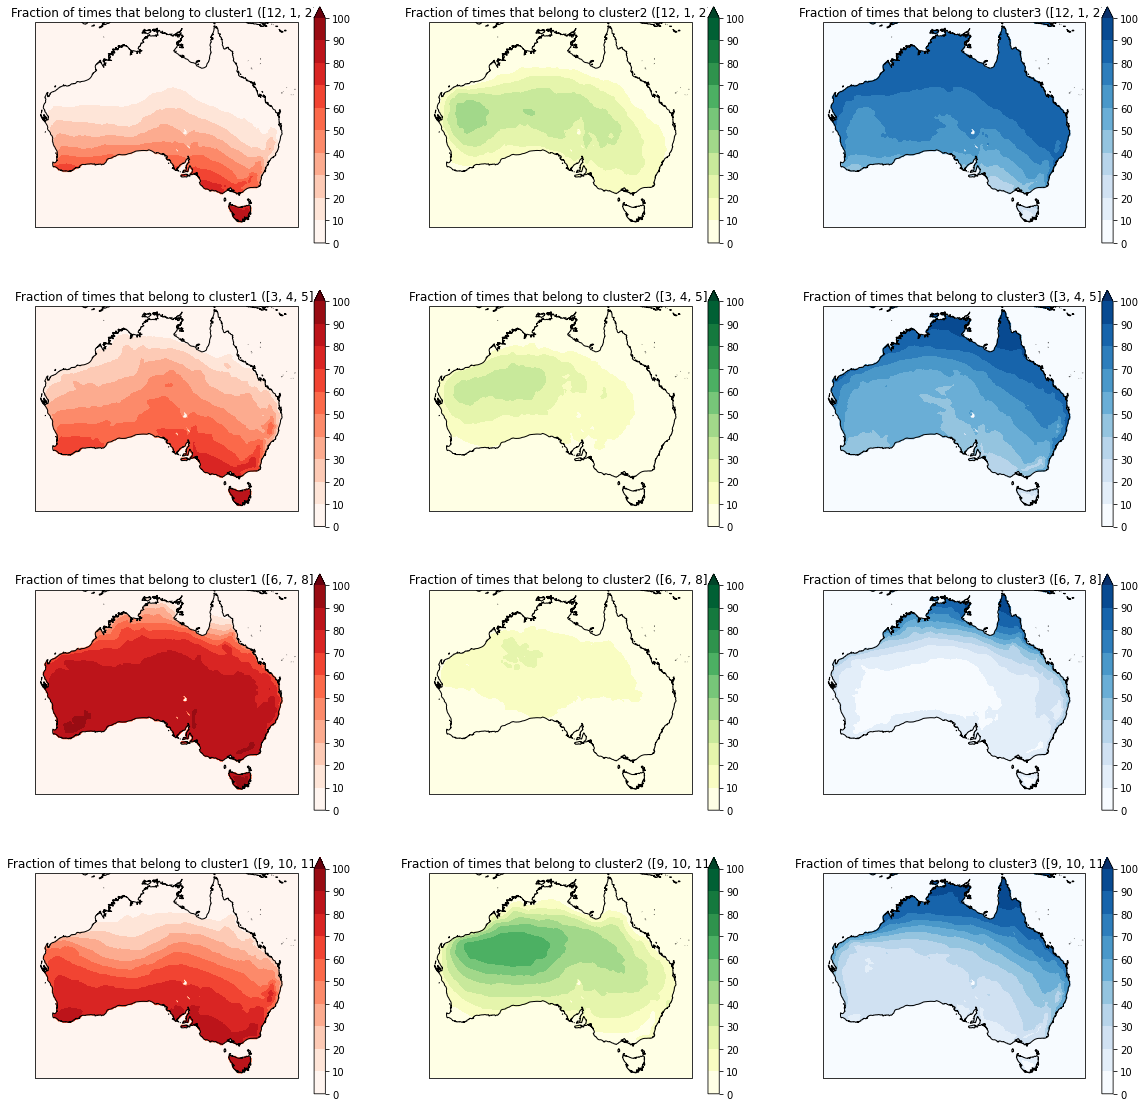

In [6]:
def plot_clim_cluster(da,times,months,ax):

    levs = np.linspace(0,100,11)

    cmaps = {"cluster1":plt.get_cmap("Reds"), "cluster2":plt.get_cmap("YlGn"), "cluster3":plt.get_cmap("Blues")}
    
    c=xr.plot.contourf((da.sel({"time":np.in1d([t.month for t in times],months)}).sum("time") / (2006-1979)).median("models"), 
                       cmap=cmaps[da.name],levels=levs, ax=ax, extend="max",add_colorbar=False)
    ax.coastlines("10m")
    cb=plt.colorbar(c)
    cb.set_ticks(levs)
    plt.title("Fraction of times that belong to " + da.name + " (" + str(season) + ")")
    
plt.figure(figsize=[20,20])
iters = product(([12,1,2],[3,4,5],[6,7,8],[9,10,11]), (f.cluster1, f.cluster2, f.cluster3))
cnt=1
for season, da in iters:
    plot_clim_cluster(da, times, season, plt.subplot(4,3,cnt,projection=ccrs.PlateCarree()))
    cnt=cnt+1

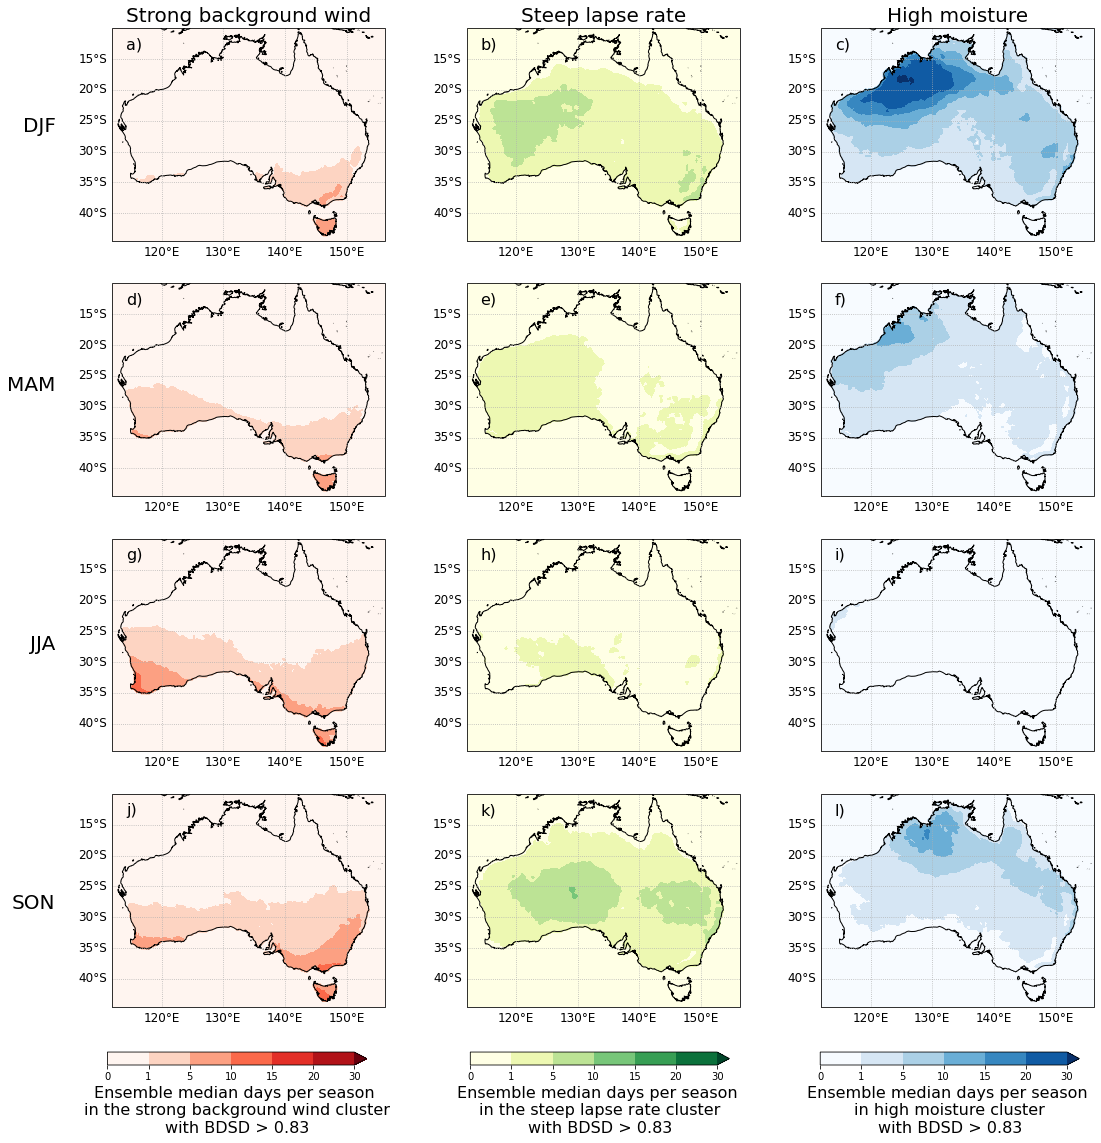

In [58]:
def plot_clim_bdsd(da,times,months,ax,letter):
    
    cmaps = {"cluster1_bdsd":plt.get_cmap("Reds"), "cluster2_bdsd":plt.get_cmap("YlGn"), "cluster3_bdsd":plt.get_cmap("Blues"), "clusterall_bdsd":plt.get_cmap("Greys")}
    
    c=xr.plot.contourf((da.sel({"time":np.in1d([t.month for t in times],months)}).sum("time") / (2006-1979)).median("models"), 
                       cmap=cmaps[da.name],levels=[0,1,5,10,15,20,30], ax=ax, extend="max",add_colorbar=False)
    ax.coastlines("10m")
    g=ax.gridlines(draw_labels=True,linestyle=":"); g.top_labels=False; g.right_labels=False
    g.xlabel_style={"size":12}
    g.ylabel_style={"size":12}
    g.xformatter = LONGITUDE_FORMATTER
    g.yformatter = LATITUDE_FORMATTER     
    ax.text(0.05,0.9,letter+")",size=16,transform=ax.transAxes)
    #cb=plt.colorbar(c)
    #cb.set_ticks(levs)
    #plt.title("Days in "+ da.name.split("_")[0] +"\n and have BDSD > 0.83"+ " (" + str(season) + ")")
    return c


fig=plt.figure(figsize=[18,18])
iters = product(([12,1,2],[3,4,5],[6,7,8],[9,10,11]), (f.cluster1_bdsd, f.cluster2_bdsd, f.cluster3_bdsd))
cnt=1
letters=["a","b","c","d","e","f","g","h","i","j","k","l","m","n","o","p"]
for season, da in iters:
    c=plot_clim_bdsd(da, times, season, plt.subplot(4,3,cnt,projection=ccrs.PlateCarree()),letters[cnt-1])
    if cnt==1:
        plt.title("Strong background wind",size=20)
    elif cnt==2:
        plt.title("Steep lapse rate",size=20)
    elif cnt==3:
        plt.title("High moisture",size=20)        
    cnt=cnt+1
    
    if cnt==11:
        cb=plt.colorbar(c,cax=plt.axes([0.13,0.08,0.2,0.01]),orientation="horizontal")
        cb.set_ticks([0,1,5,10,15,20,30])    
        cb.set_label("Ensemble median days per season \nin the strong background wind cluster\nwith BDSD > 0.83",size=16)    
    elif cnt==12:
        cb=plt.colorbar(c,cax=plt.axes([0.41,0.08,0.2,0.01]),orientation="horizontal")
        cb.set_ticks([0,1,5,10,15,20,30])    
        cb.set_label("Ensemble median days per season \nin the steep lapse rate cluster\nwith BDSD > 0.83",size=16)    
    elif cnt==13:
        cb=plt.colorbar(c,cax=plt.axes([0.68,0.08,0.2,0.01]),orientation="horizontal")
        cb.set_ticks([0,1,5,10,15,20,30])    
        cb.set_label("Ensemble median days per season \nin high moisture cluster\nwith BDSD > 0.83",size=16)              
        
    
ylab="DJF"
fig.text(0.09,0.8,ylab,size=20,ha="right")
ylab="MAM"
fig.text(0.09,0.6,ylab,size=20,ha="right")        
ylab="JJA"
fig.text(0.09,0.4,ylab,size=20,ha="right")        
ylab="SON"
fig.text(0.09,0.2,ylab,size=20,ha="right")     

plt.savefig("/g/data/eg3/ab4502/figs/ExtremeWind/cmip5_cluster_historical_clim.jpeg",dpi=300,bbox_inches="tight",transparent=True)    

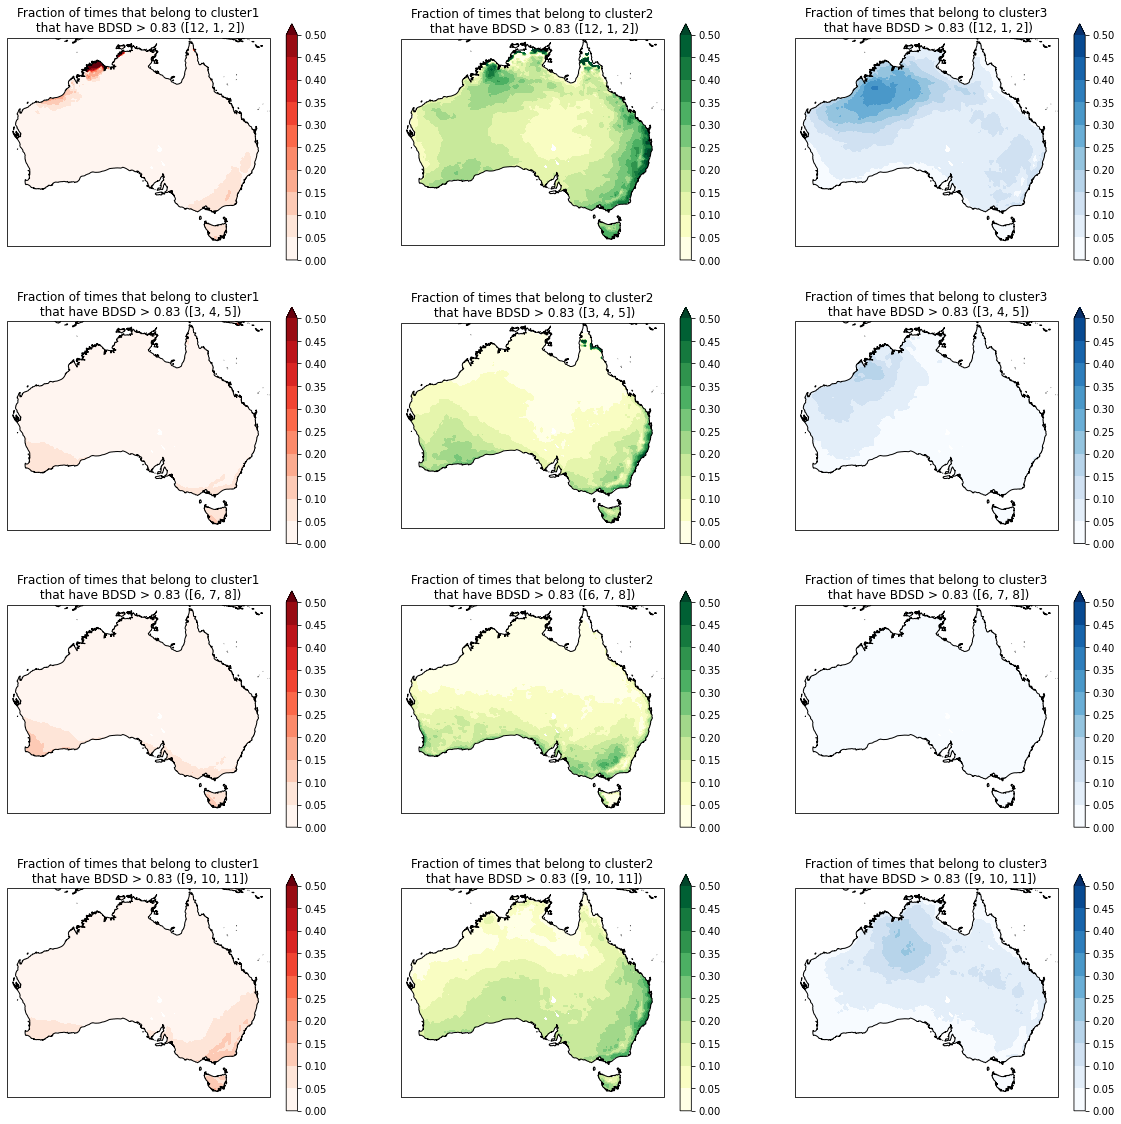

In [8]:
def plot_bdsd_frac(da_cluster,da_bdsd,times,months,ax):

    levs = np.linspace(0,0.5,11)
    
    cmaps = {"cluster1_bdsd":plt.get_cmap("Reds"), "cluster2_bdsd":plt.get_cmap("YlGn"), "cluster3_bdsd":plt.get_cmap("Blues"), "clusterall_bdsd":plt.get_cmap("Greys")}
    
    c=xr.plot.contourf((da_bdsd.sel({"time":np.in1d([t.month for t in times],months)}).sum("time")
                       / da_cluster.sel({"time":np.in1d([t.month for t in times],months)}).sum("time")).median("models"), 
                       cmap=cmaps[da_bdsd.name],levels=levs, ax=ax,add_colorbar=False,extend="max")
    ax.coastlines("10m")
    cb=plt.colorbar(c)
    cb.set_ticks(levs)
    plt.title("Fraction of times that belong to "+ da[0].name.split("_")[0] +"\n that have BDSD > 0.83"+ " (" + str(season) + ")")
    


plt.figure(figsize=[20,20])
iters = product(([12,1,2],[3,4,5],[6,7,8],[9,10,11]), zip((f.cluster1,f.cluster2,f.cluster3),(f.cluster1_bdsd, f.cluster2_bdsd, f.cluster3_bdsd)))
cnt=1
for season, da in iters:
    plot_bdsd_frac(da[0], da[1], times, season, plt.subplot(4,3,cnt,projection=ccrs.PlateCarree()))
    cnt=cnt+1

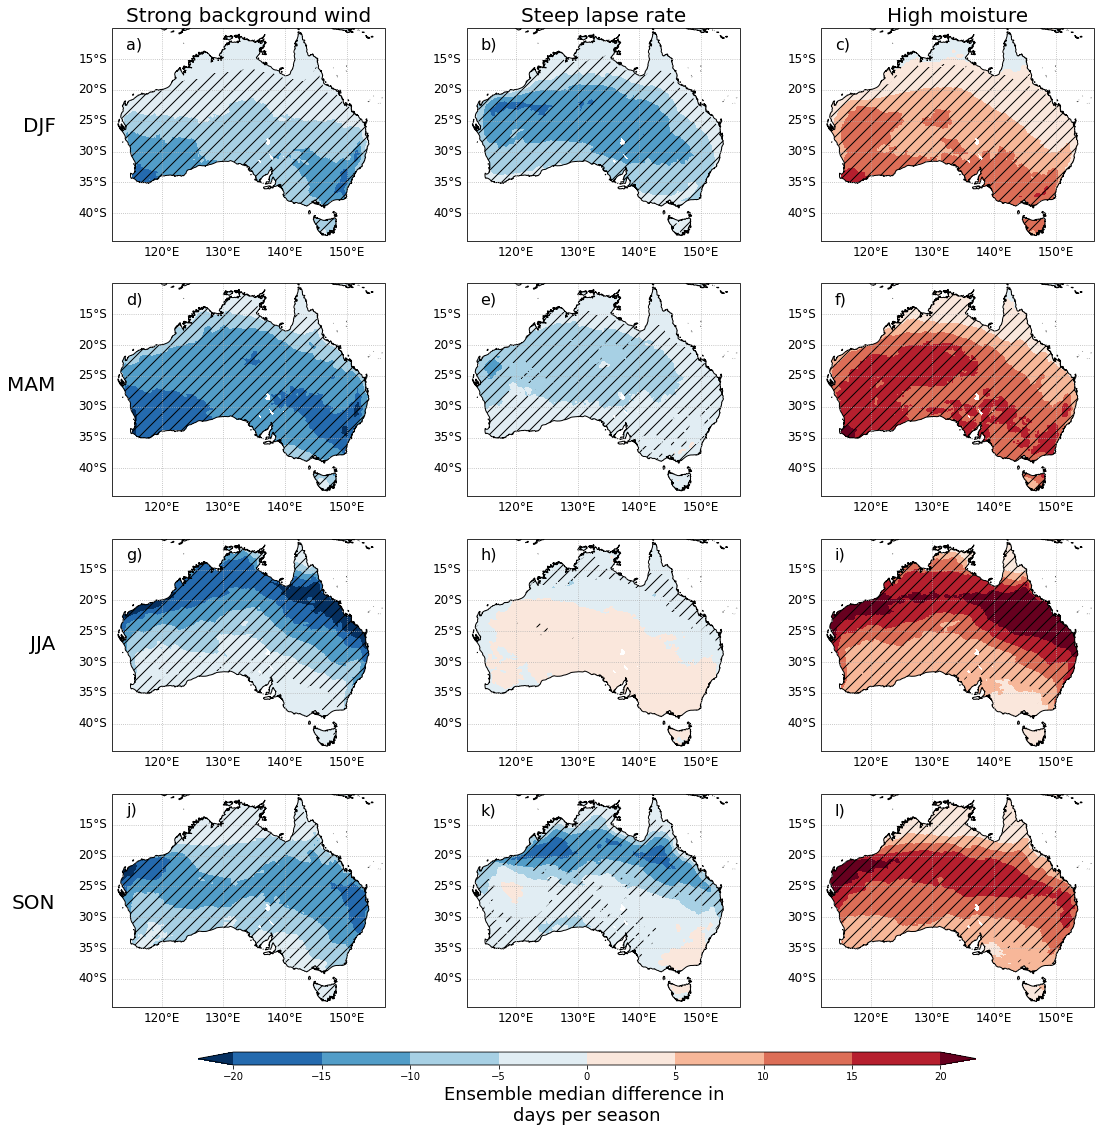

In [59]:
def plot_diff(da1,da2,times1,times2,months,ax,letter):

    levs=np.arange(-20,25,5)
    
    c=xr.plot.contourf(((da2.sel({"time":np.in1d([t.month for t in times2],months)}).sum("time",skipna=False) / (2101-2081)) - 
                       (da1.sel({"time":np.in1d([t.month for t in times1],months)}).sum("time",skipna=False) / (2006-1979))).median("models"), 
                       cmap=plt.get_cmap("RdBu_r"),levels=levs, ax=ax, extend="both",add_colorbar=False)
    
    sig=(((((da2.sel({"time":np.in1d([t.month for t in times2],months)}).sum("time") / (2101-2081)) - 
                       (da1.sel({"time":np.in1d([t.month for t in times1],months)}).sum("time") / (2006-1979))) > 0).sum("models")) >= 10) +\
        (((((da2.sel({"time":np.in1d([t.month for t in times2],months)}).sum("time") / (2101-2081)) - 
                       (da1.sel({"time":np.in1d([t.month for t in times1],months)}).sum("time") / (2006-1979))) < 0).sum("models")) >= 10)
    sig=xr.where((da1.sel({"time":np.in1d([t.month for t in times1],months)}).sum("time") / (2006-1979)).mean("models")>=1, sig, 0)
    xr.plot.contourf(sig*1, colors="none", hatches=[None,"//"], add_colorbar=False, add_labels=False, ax=ax, levels=[0.5,1.5])        
    
    ax.coastlines("10m")
    g=ax.gridlines(draw_labels=True,linestyle=":"); g.top_labels=False; g.right_labels=False
    g.xlabel_style={"size":12}
    g.ylabel_style={"size":12}
    g.xformatter = LONGITUDE_FORMATTER
    g.yformatter = LATITUDE_FORMATTER     
    ax.text(0.05,0.9,letter+")",size=16,transform=ax.transAxes)    
#    cb=plt.colorbar(c)
##    cb.set_ticks(levs)
#    plt.title("Difference in days that belong to " + da1.name + " (" + str(season) + ")")

    return c

fig=plt.figure(figsize=[18,18])
iters = product(([12,1,2],[3,4,5],[6,7,8],[9,10,11]), zip((f.cluster1, f.cluster2, f.cluster3),(r.cluster1,r.cluster2,r.cluster3)))
cnt=1
for season, da in iters:
    c=plot_diff(da[0], da[1], times, times2, season, plt.subplot(4,3,cnt,projection=ccrs.PlateCarree()),letters[cnt-1])
    if cnt==1:
        plt.title("Strong background wind",size=20)
    elif cnt==2:
        plt.title("Steep lapse rate",size=20)
    elif cnt==3:
        plt.title("High moisture",size=20)       
    cnt=cnt+1
    
cb=plt.colorbar(c,cax=plt.axes([0.2,0.08,0.6,0.01]),orientation="horizontal")
cb.set_ticks(np.arange(-20,25,5))    
cb.set_label("Ensemble median difference in \ndays per season",size=18)    
    
ylab="DJF"
fig.text(0.09,0.8,ylab,size=20,ha="right")
ylab="MAM"
fig.text(0.09,0.6,ylab,size=20,ha="right")        
ylab="JJA"
fig.text(0.09,0.4,ylab,size=20,ha="right")        
ylab="SON"
fig.text(0.09,0.2,ylab,size=20,ha="right")          
    
plt.savefig("/g/data/eg3/ab4502/figs/ExtremeWind/cmip5_cluster_projections.jpeg",dpi=300,bbox_inches="tight",transparent=True)    

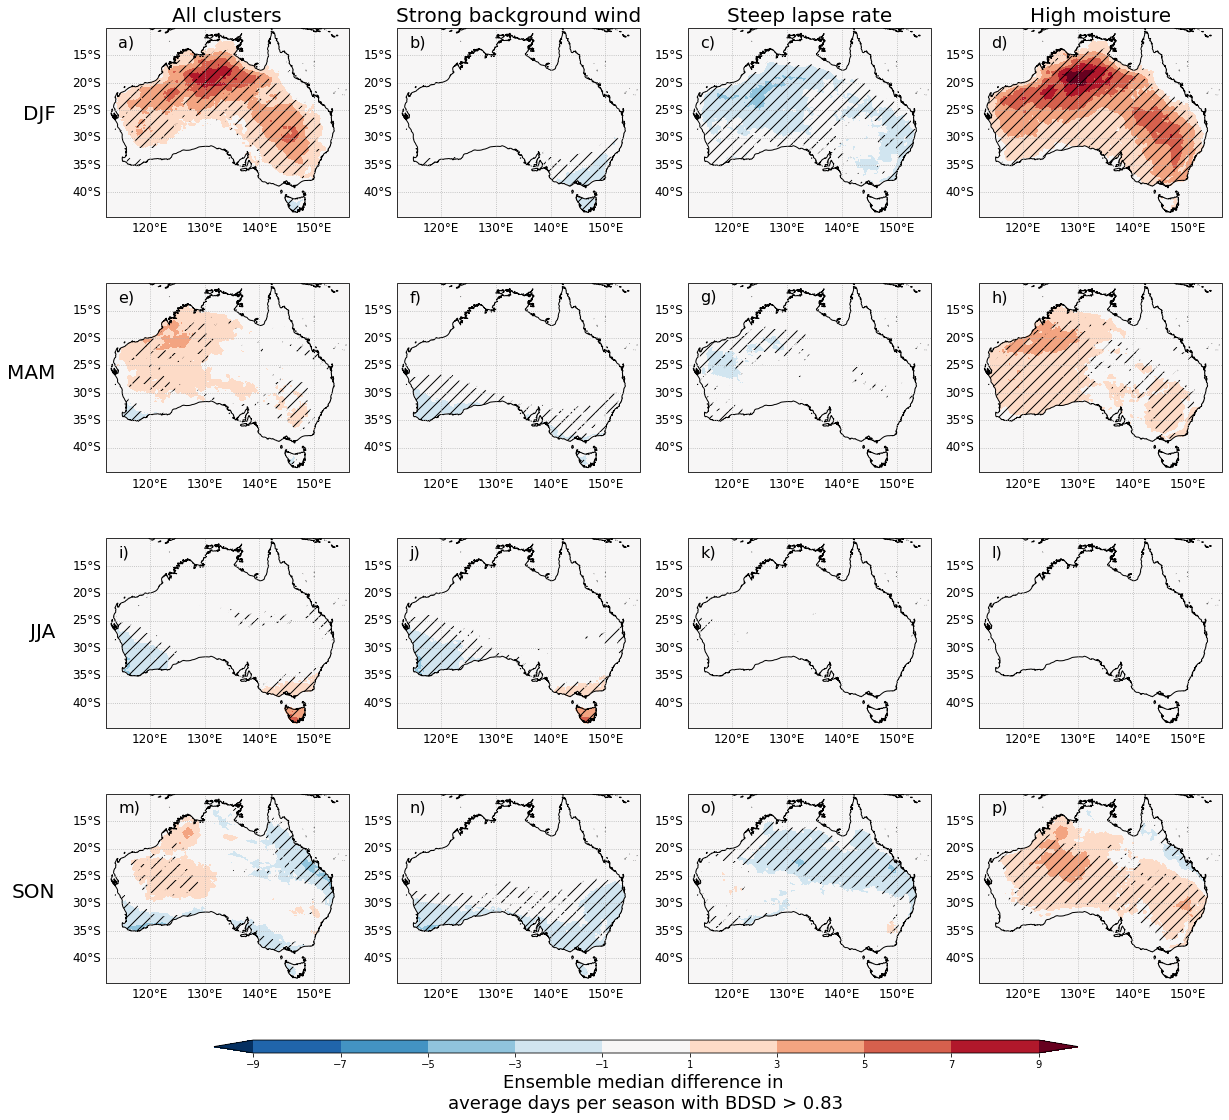

In [62]:
def plot_bdsd_diff(da1,da2,times1,times2,months,ax,ylab,letter):

    levs = [-9,-7,-5,-3,-1,1,3,5,7,9]
    
    c=xr.plot.contourf(((da2.sel({"time":np.in1d([t.month for t in times2],months)}).sum("time") / (2101-2081)) - 
                       (da1.sel({"time":np.in1d([t.month for t in times1],months)}).sum("time") / (2006-1979))).median("models"), 
                       cmap=plt.get_cmap("RdBu_r"),levels=levs, ax=ax, extend="both",add_colorbar=False)
    sig=(((((da2.sel({"time":np.in1d([t.month for t in times2],months)}).sum("time") / (2101-2081)) - 
                       (da1.sel({"time":np.in1d([t.month for t in times1],months)}).sum("time") / (2006-1979))) > 0).sum("models")) >= 10) +\
        (((((da2.sel({"time":np.in1d([t.month for t in times2],months)}).sum("time") / (2101-2081)) - 
                       (da1.sel({"time":np.in1d([t.month for t in times1],months)}).sum("time") / (2006-1979))) < 0).sum("models")) >= 10)
    sig=xr.where((da1.sel({"time":np.in1d([t.month for t in times1],months)}).sum("time") / (2006-1979)).mean("models")>=1, sig, 0)
    xr.plot.contourf(sig*1, colors="none", hatches=[None,"//"], add_colorbar=False, add_labels=False, ax=ax, levels=[0.5,1.5])    
        
    ax.coastlines("10m")
    g=ax.gridlines(draw_labels=True,linestyle=":"); g.top_labels=False; g.right_labels=False
    g.xlabel_style={"size":12}
    g.ylabel_style={"size":12}
    g.xformatter = LONGITUDE_FORMATTER
    g.yformatter = LATITUDE_FORMATTER  
    ax.text(0.05,0.9,letter+")",size=16,transform=ax.transAxes)
    #plt.title("Difference in times that belong to " + da1.name + " \nand have BDSD>0.83 (" + str(season) + ")")
    
    
    
    return c

fig=plt.figure(figsize=[20,18])
iters = product(([12,1,2],[3,4,5],[6,7,8],[9,10,11]), zip((f.clusterall_bdsd,f.cluster1_bdsd, f.cluster2_bdsd, f.cluster3_bdsd),
                                                          (r.clusterall_bdsd,r.cluster1_bdsd,r.cluster2_bdsd,r.cluster3_bdsd)))
cnt=1
for season, da in iters:  
        
    c=plot_bdsd_diff(da[0], da[1], times, times2, season, plt.subplot(4,4,cnt,projection=ccrs.PlateCarree()),"",letters[cnt-1])
    if cnt==1:
        plt.title("All clusters",size=20)
    elif cnt==2:
        plt.title("Strong background wind",size=20)
    elif cnt==3:
        plt.title("Steep lapse rate",size=20)
    elif cnt==4:
        plt.title("High moisture",size=20)        
              
    cnt=cnt+1
    
cb=plt.colorbar(c,cax=plt.axes([0.2,0.08,0.6,0.01]),orientation="horizontal")
cb.set_ticks([-9,-7,-5,-3,-1,1,3,5,7,9])    
cb.set_label("Ensemble median difference in \naverage days per season with BDSD > 0.83",size=18)

ylab="DJF"
fig.text(0.09,0.8,ylab,size=20,ha="right")
ylab="MAM"
fig.text(0.09,0.6,ylab,size=20,ha="right")        
ylab="JJA"
fig.text(0.09,0.4,ylab,size=20,ha="right")        
ylab="SON"
fig.text(0.09,0.2,ylab,size=20,ha="right")  

plt.savefig("/g/data/eg3/ab4502/figs/ExtremeWind/cmip5_cluster_projections_bdsd.jpeg",dpi=300,bbox_inches="tight",transparent=True)

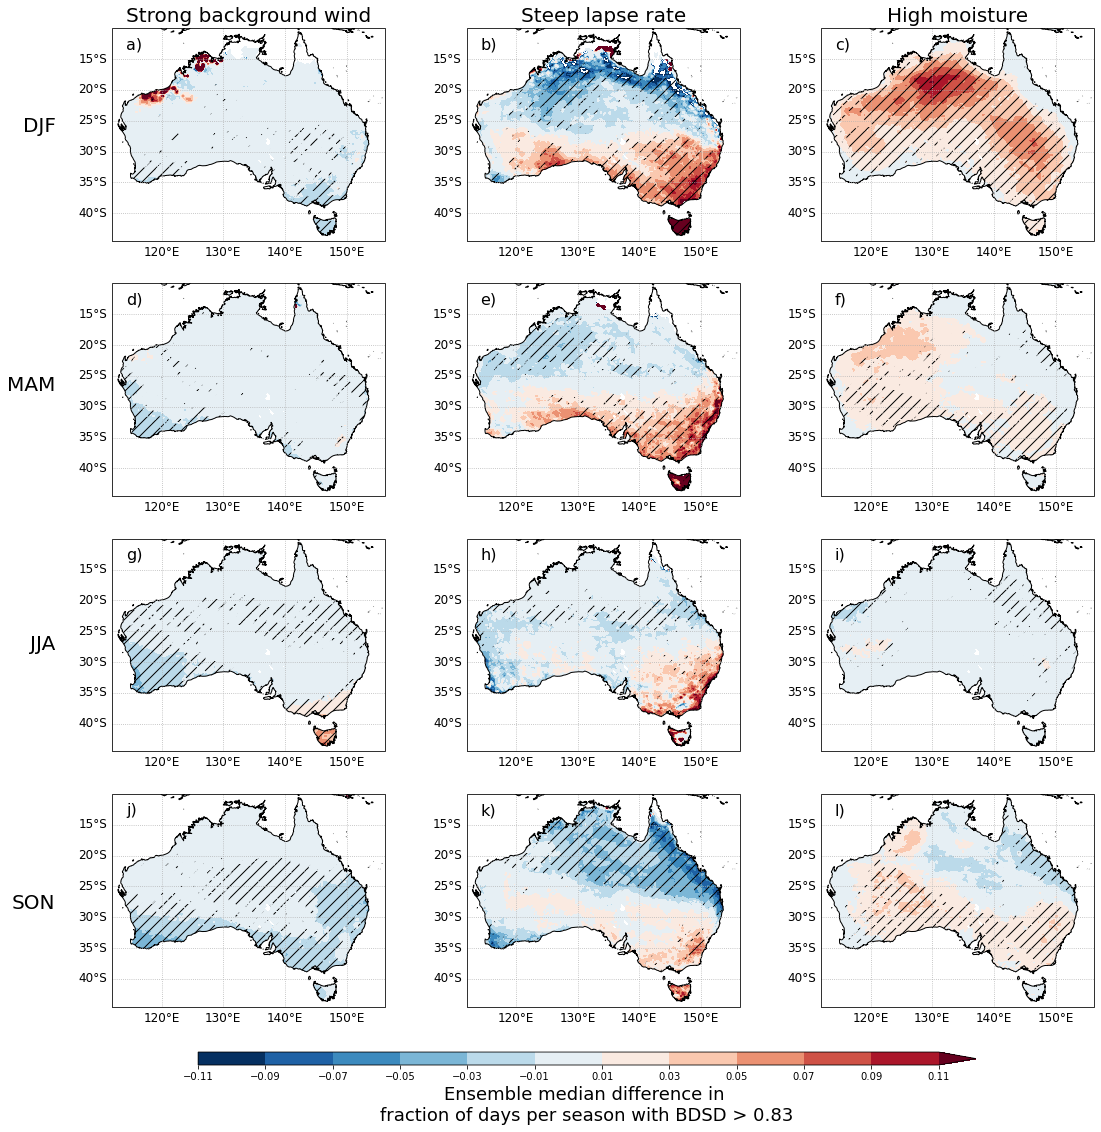

In [61]:
def plot_bdsd_frac_diff(da_cluster,da_cluster2,da_bdsd,da_bdsd2,times1,times2,months,ax,letter):

    #levs = np.linspace(0,0.5,11)
    levs=np.linspace(-0.11,0.11,12)
    
    frac1 = (da_bdsd.sel({"time":np.in1d([t.month for t in times1],months)}).sum("time")
                       / da_cluster.sel({"time":np.in1d([t.month for t in times1],months)}).sum("time"))
    frac2 = (da_bdsd2.sel({"time":np.in1d([t.month for t in times2],months)}).sum("time")
                       / da_cluster2.sel({"time":np.in1d([t.month for t in times2],months)}).sum("time"))    
    diff = frac2 - frac1
    sig = ((diff>0).sum("models") >= 10) + ((diff<0).sum("models") >= 10)
    
    c=xr.plot.contourf(diff.median("models"), 
                       cmap=plt.get_cmap("RdBu_r"),levels=levs, ax=ax,add_colorbar=False,extend="max")
    xr.plot.contourf(sig*1, colors="none", hatches=[None,"//"], add_colorbar=False, add_labels=False, ax=ax, levels=[0.5,1.5])        
    ax.coastlines("10m")
    g=ax.gridlines(draw_labels=True,linestyle=":"); g.top_labels=False; g.right_labels=False
    g.xlabel_style={"size":12}
    g.ylabel_style={"size":12}
    g.xformatter = LONGITUDE_FORMATTER
    g.yformatter = LATITUDE_FORMATTER   
    ax.text(0.05,0.9,letter+")",size=16,transform=ax.transAxes)
    # cb=plt.colorbar(c)
    # cb.set_ticks(levs)
    #plt.title("Change in fraction of "+ da[0].name.split("_")[0] +" days\n that have BDSD > 0.83"+ " (" + str(season) + ")")
    
    return c
    


fig=plt.figure(figsize=[18,18])
iters = product(([12,1,2],[3,4,5],[6,7,8],[9,10,11]), 
                zip(
                    (f.cluster1,f.cluster2,f.cluster3),
                    (r.cluster1, r.cluster2, r.cluster3),
                    (f.cluster1_bdsd,f.cluster2_bdsd,f.cluster3_bdsd),
                    (r.cluster1_bdsd, r.cluster2_bdsd, r.cluster3_bdsd),                    
                )
               )
cnt=1
for season, da in iters:
    da_cluster,da_cluster2,da_bdsd,da_bdsd2 = da
    c=plot_bdsd_frac_diff(da_cluster,da_cluster2,da_bdsd,da_bdsd2,times,times2,season, plt.subplot(4,3,cnt,projection=ccrs.PlateCarree()),letters[cnt-1])
    
    if cnt==1:
        plt.title("Strong background wind",size=20)
    elif cnt==2:
        plt.title("Steep lapse rate",size=20)
    elif cnt==3:
        plt.title("High moisture",size=20)            
    cnt=cnt+1
    
cb=plt.colorbar(c,cax=plt.axes([0.2,0.08,0.6,0.01]),orientation="horizontal")
cb.set_ticks(np.linspace(-0.11,0.11,12))    
cb.set_label("Ensemble median difference in \nfraction of days per season with BDSD > 0.83",size=18)    
    
ylab="DJF"
fig.text(0.09,0.8,ylab,size=20,ha="right")
ylab="MAM"
fig.text(0.09,0.6,ylab,size=20,ha="right")        
ylab="JJA"
fig.text(0.09,0.4,ylab,size=20,ha="right")        
ylab="SON"
fig.text(0.09,0.2,ylab,size=20,ha="right")      
    
plt.savefig("/g/data/eg3/ab4502/figs/ExtremeWind/cmip5_cluster_projections_frac.jpeg",dpi=300,bbox_inches="tight",transparent=True)    